## Silkworm Rearing Segmentation Notebook
Sections:
1 Imports
2 Configuration
3 Utility functions
4 Data loading
5 SAM model initialization
6 Segmentation loop
7 Visualization

In [ ]:
# 1 Imports
import os
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

In [ ]:
# 2 Configuration
device = "cuda" if torch.cuda.is_available() else "cpu"

sam_model_type       = "vit_b"
sam_checkpoint_url   = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"
sam_checkpoint_path  = "sam_vit_b_01ec64.pth"

image_directory      = "data/images"
number_of_samples    = 3

fourier_radius       = 30
green_hue_min        = 40
green_hue_max        = 90
green_saturation_boost = 1.5
red_hue_low          = 20
red_hue_high         = 160

clahe_clip_limit     = 2.0
clahe_tile_size      = (8, 8)
min_mask_area        = 500

In [ ]:
# 3 Utility functions
def download_checkpoint(url, destination):
    if not os.path.exists(destination):
        import requests
        print("Downloading SAM checkpoint…")
        response = requests.get(url, allow_redirects=True)
        with open(destination, "wb") as f:
            f.write(response.content)
        print("Download complete")

def apply_gray_world(image):
    img32 = image.astype(np.float32)
    channel_means = img32.mean(axis=(0, 1))
    scale = channel_means.mean() / (channel_means + 1e-6)
    balanced = img32 * scale
    return np.clip(balanced, 0, 255).astype(np.uint8)

def high_pass_filter(gray_image, radius=fourier_radius):
    h, w = gray_image.shape
    cy, cx = h // 2, w // 2
    dft = cv2.dft(gray_image.astype(np.float32), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    mask = np.ones((h, w, 2), np.uint8)
    mask[cy - radius : cy + radius, cx - radius : cx + radius] = 0
    fshift = dft_shift * mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv2.idft(f_ishift)
    mag = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])
    return cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

def preprocess_image(image_rgb):
    # white balance and contrast
    balanced = apply_gray_world(image_rgb)
    lab = cv2.cvtColor(balanced, cv2.COLOR_RGB2LAB)
    L, A, B = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clahe_clip_limit, tileGridSize=clahe_tile_size)
    L_eq = clahe.apply(L)
    contrast = cv2.cvtColor(cv2.merge((L_eq, A, B)), cv2.COLOR_LAB2RGB)

    # edge enhancement
    gray = cv2.cvtColor(contrast, cv2.COLOR_RGB2GRAY)
    hp = high_pass_filter(gray)
    enhanced = cv2.addWeighted(contrast, 1.0, cv2.cvtColor(hp, cv2.COLOR_GRAY2RGB), 0.5, 0)

    # hue‐based saturation boost
    hsv = cv2.cvtColor(enhanced, cv2.COLOR_RGB2HSV).astype(np.float32)
    H, S, V = hsv[..., 0], hsv[..., 1], hsv[..., 2]
    green_zone = (H >= green_hue_min) & (H <= green_hue_max)
    S[green_zone] *= green_saturation_boost
    red_zone   = (H <= red_hue_low) | (H >= red_hue_high)
    S[red_zone] *= 0.6
    hsv[..., 1] = np.clip(S, 0, 255)

    return cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)

def combine_and_filter_masks(masks, min_area=min_mask_area):
    combined = np.zeros_like(masks[0]["segmentation"], dtype=np.uint8)
    for m in masks:
        seg = m["segmentation"].astype(np.uint8)
        if seg.sum() >= min_area:
            combined |= seg
    return combined


In [ ]:
# 4 Data loading
assert os.path.isdir(image_directory), f"{image_directory} not found"
all_images = [
    fname for fname in os.listdir(image_directory)
    if fname.lower().endswith((".jpg", ".jpeg", ".png"))
]
assert all_images, "No images in directory"
random.shuffle(all_images)
sampled_images = all_images[:number_of_samples]

In [ ]:
# 5 SAM model initialization
download_checkpoint(sam_checkpoint_url, sam_checkpoint_path)

sam = sam_model_registry[sam_model_type](checkpoint=sam_checkpoint_path).to(device)
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=64,
    crop_n_layers=1,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.7,
)

Processing IMG_2969.jpg


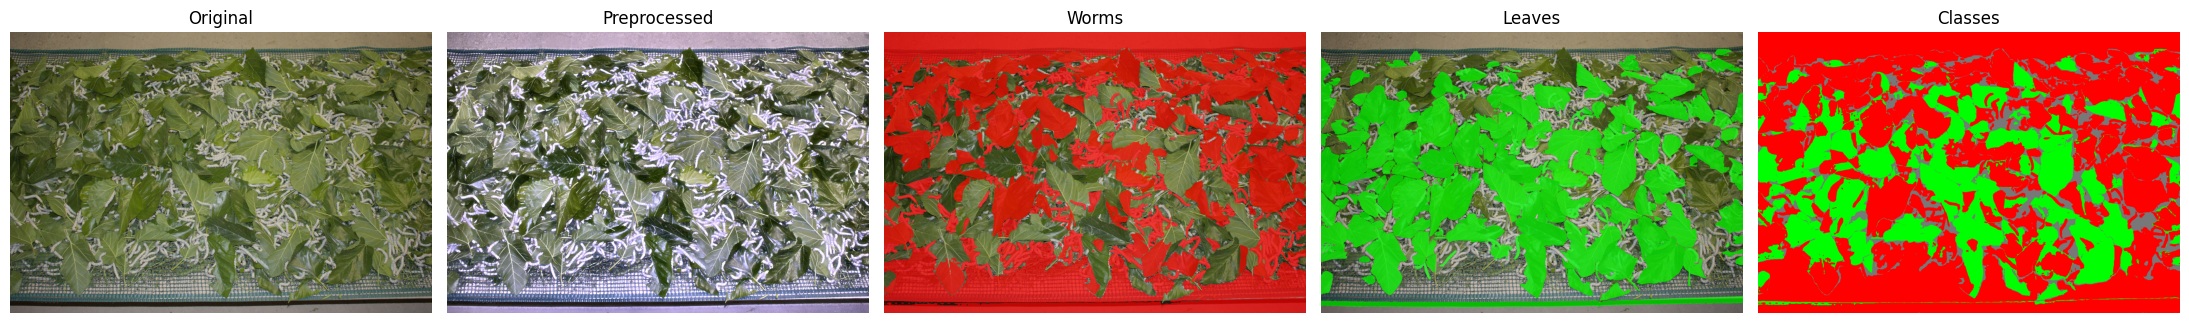

Processing IMG_3889.jpg


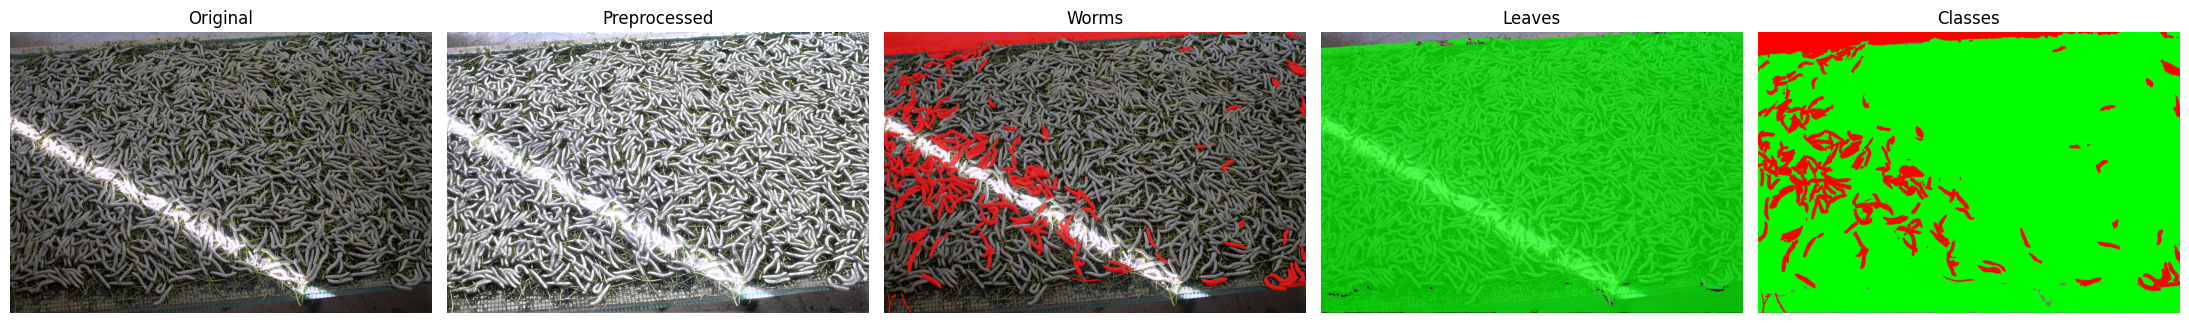

Processing IMG_3527.jpg


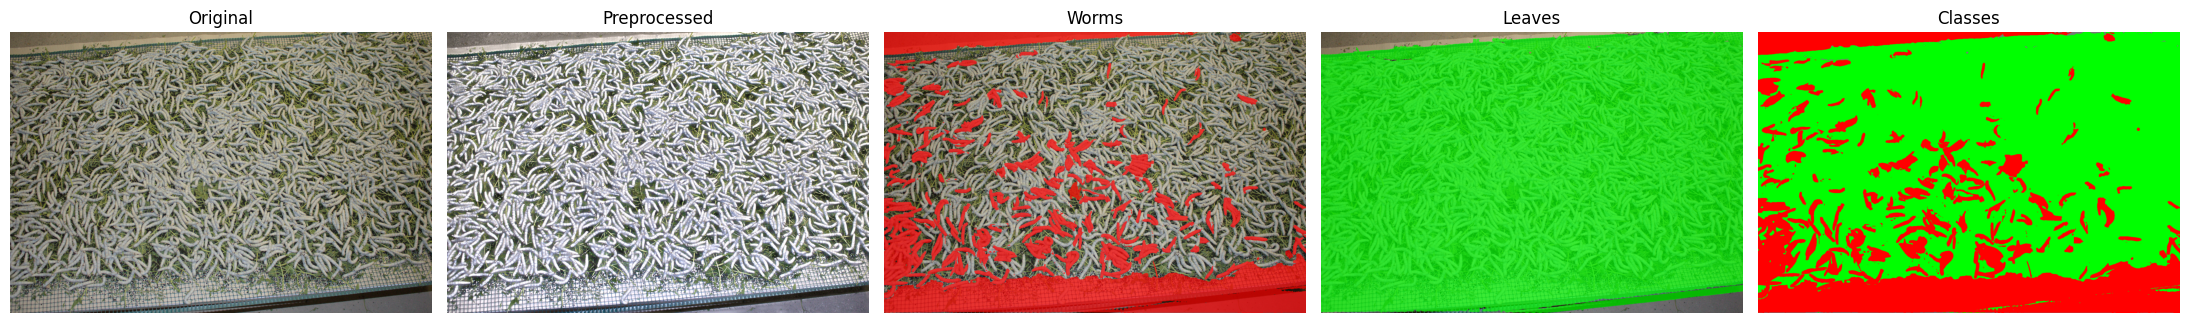

In [19]:
# 6 Segmentation loop
for fname in sampled_images:
    print("Processing", fname)
    bgr = cv2.imread(os.path.join(image_directory, fname))
    if bgr is None:
        print(f"Skipping {fname}")
        continue
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    pre = preprocess_image(rgb)
    masks = mask_generator.generate(pre)
    if not masks:
        print("No masks returned")
        continue

    hsv_pre = cv2.cvtColor(pre, cv2.COLOR_RGB2HSV)
    worm_mask = np.zeros_like(masks[0]["segmentation"], dtype=np.uint8)
    leaf_mask = worm_mask.copy()

    for m in masks:
        seg = m["segmentation"].astype(np.uint8)
        if seg.sum() < min_mask_area:
            continue
        mean_hue = cv2.mean(hsv_pre[:, :, 0], mask=seg)[0]
        if green_hue_min <= mean_hue <= green_hue_max:
            leaf_mask |= seg
        else:
            worm_mask |= seg

    # Visualization
    overlay_w = rgb.copy()
    overlay_w[worm_mask == 1] = (
        overlay_w[worm_mask == 1] * 0.3 + np.array([255, 0, 0]) * 0.7
    ).astype(np.uint8)
    overlay_l = rgb.copy()
    overlay_l[leaf_mask == 1] = (
        overlay_l[leaf_mask == 1] * 0.3 + np.array([0, 255, 0]) * 0.7
    ).astype(np.uint8)
    combined = np.full(rgb.shape, 120, dtype=np.uint8)
    combined[leaf_mask == 1] = [0, 255, 0]
    combined[worm_mask == 1] = [255, 0, 0]

    fig, axes = plt.subplots(1, 5, figsize=(22, 4))
    for ax, img, title in zip(
        axes,
        [rgb, pre, overlay_w, overlay_l, combined],
        ["Original", "Preprocessed", "Worms", "Leaves", "Classes"]
    ):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis("off")
    plt.tight_layout()
    plt.show()
